# Stencil Calculations with Numba

In [14]:
import numpy as np
import numba
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## 1D Heat equation
\begin{align}
\frac{\partial u}{\partial t} &= \alpha\frac{\partial^2u}{\partial x^2},\quad\quad &\text{$x\in (0,L), t \in (0, T]$} \\
u(x,0)&=I_0(x),\quad\quad &\text{$x \in [0, L]$} \\
u(0,t) &= 0,\quad\quad & t>0 \\
u(L,t) &= 0,\quad\quad & t>0
\end{align}

## Discretization of the Heat equation

\begin{align}
\text{space discretization:}\quad\quad\quad\quad\quad x_i &=i \Delta x, \quad i=0,\ldots,Nx\\
\text{time discretization:}\quad\quad\quad\quad\quad t_n &= n\Delta t, \quad n = 0,\ldots, N_t \\
\frac{u_i^{n+1}-u_i^n}{\Delta t} &= \alpha \frac{u_{i+1}^n-2u_i^n+u_{i-1}^n}{\Delta x^2}\\
u_i^{n+1} &= u_i^n + F \left( u_{i+1}^n -2 u_i^n + u_{i-1}^n\right) \\
\text{mesh Fourier number:}\quad\quad\quad\quad\quad F &= \alpha \frac{\Delta t}{\Delta x ^2}
\end{align}

In [15]:
nx = 500
nt = 10000
T = 100.0
L = 100.0
dx = L / nx
dt = T / nt
alpha = 1.0
F = alpha * dt / dx ** 2 
print(F)
x = np.linspace(0, L, nx + 1)
temp = np.zeros(nx + 1)
temp[nx//2:nx//2+nx//10] = np.sin(2.0 * np.pi * (x[nx//2:nx//2+nx//10] - x[nx//2])/(L/5))

0.24999999999999994


In [16]:
@numba.stencil
def central_diff_stencil(x, F):
    return x[0]  + F * (x[1] - 2.0 * x[0] + x[-1])

In [17]:
@numba.njit
def simulation(x, F, nt):
    for i in range(nt):
        x = central_diff_stencil(x, F)
    
    return x

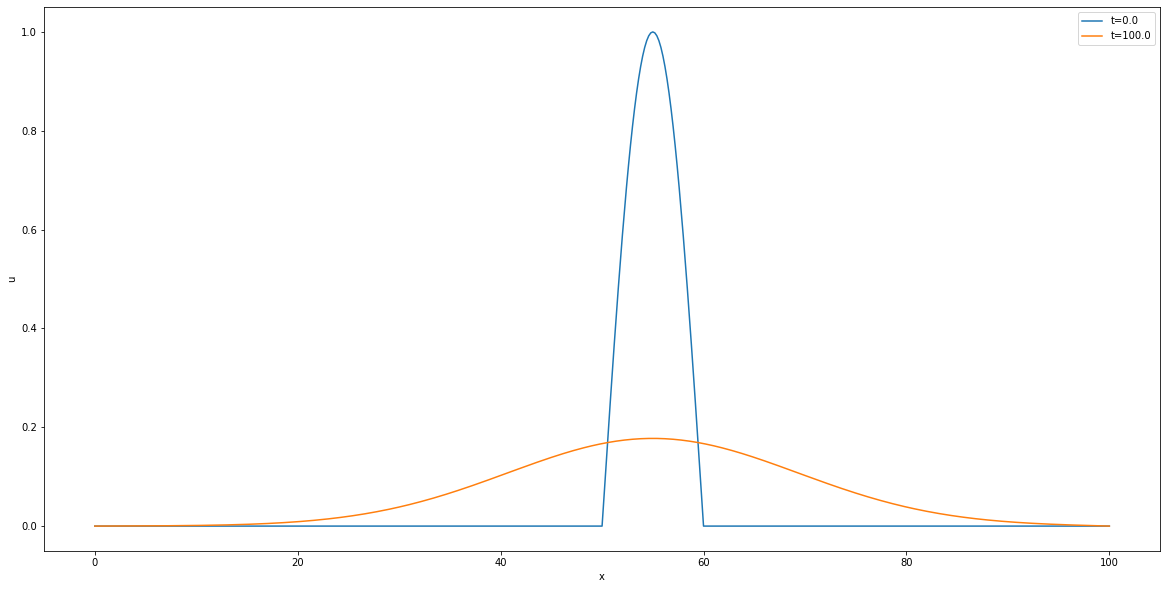

In [18]:
temp_final = simulation(temp, F, nt)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(x, temp, label='t=0.0')
ax.plot(x, temp_final, label=f't={T}')
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend();

## 2D Heat equation

\begin{align}
\frac{\partial u}{\partial t} &= \alpha\left(\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} \right),\quad\quad & x \in (0,L_x),\quad\quad y \in (0, L_y) \quad\quad t \in (0, T] \\
u(x, y, 0)&=I_0(x, y),\quad\quad & x \in [0, L_x],\quad\quad y \in [0, L_y] \\
\end{align}

## Discretization of the 2D Heat equation

\begin{align}
\text{space discretization $x$:}&\quad\quad\quad\quad\quad x_i =i \Delta x, \quad i=0,\ldots,Nx\\
\text{space discretization $y$:}&\quad\quad\quad\quad\quad y_j =j \Delta y, \quad j=0,\ldots,Ny\\
\text{time discretization:}&\quad\quad\quad\quad\quad t_n = n\Delta t, \quad n = 0,\ldots, N_t \\
u_{i,j}^{n+1} &= u_{i,j}^k + \alpha \Delta t  \left(\frac{u_{i-1,j}^n-2u_{i,j}^k+u_{i+1,j}^n}{\Delta x^2}\right) + \alpha \Delta t \left(\frac{u_{i,j-1}^n-2u_{i,j}^n+u_{i,j+1}^n}{\Delta y^2} \right) \\
u_{i,j}^{n+1} &= u_{i,j}^n +F_x  \left(u_{i-1,j}^n-2u_{i,j}^n+u_{i+1,j}^n\right) + F_y \left(u_{i,j-1}^n-2u_{i,j}^n+u_{i,j+1}^n\right) \\
\text{where}&,\quad\quad F_x=\frac{\alpha \Delta t}{\Delta x^2},\quad\quad F_y=\frac{\alpha \Delta t}{\Delta y^2}
\end{align}

## 5-Point Stencil
![Five Point Stencil](Stencil.jpg)

In [19]:
nx = 400
ny = 400
nt = 10000
T = 100.0
Lx = 10.0
Ly = 10.0
dx = L / nx
dy = L / ny
dt = T / nt
alpha = 1.0
Fx = alpha * dt / dx ** 2 
Fy = alpha * dt / dx ** 2 
#print(Fx, Fy)
X, Y = np.meshgrid(np.linspace(0, Lx, nx + 1), np.linspace(0, Ly, ny + 1), indexing='ij')
temp = np.zeros((ny + 1, nx + 1))
temp = 1.0 * np.exp(-(X - Lx / 2.0) **2 / 2  - (Y - Ly / 2.0) ** 2 / 2) # Initial conditions
temp[(X == 0.0) | (Y == 0.0) | (X == L) | (Y == Ly)] = 0.0 # Boundary conditions

In [9]:
@numba.stencil
def central_diff_stencil2D(x, Fx, Fy):
    return (x[0, 0]  + Fx * (x[-1, 0] - 2.0 * x[0, 0] + x[1, 0]) + 
            + Fy * (x[0, -1] - 2.0 * x[0, 0] + x[0, 1]))

In [20]:
@numba.njit
def simulation2D(x, Fx, Fy, nt):
    for i in range(nt):
        x = central_diff_stencil2D(x, Fx, Fy)
    
    return x

CPU times: user 3.25 s, sys: 18.4 ms, total: 3.27 s
Wall time: 3.4 s


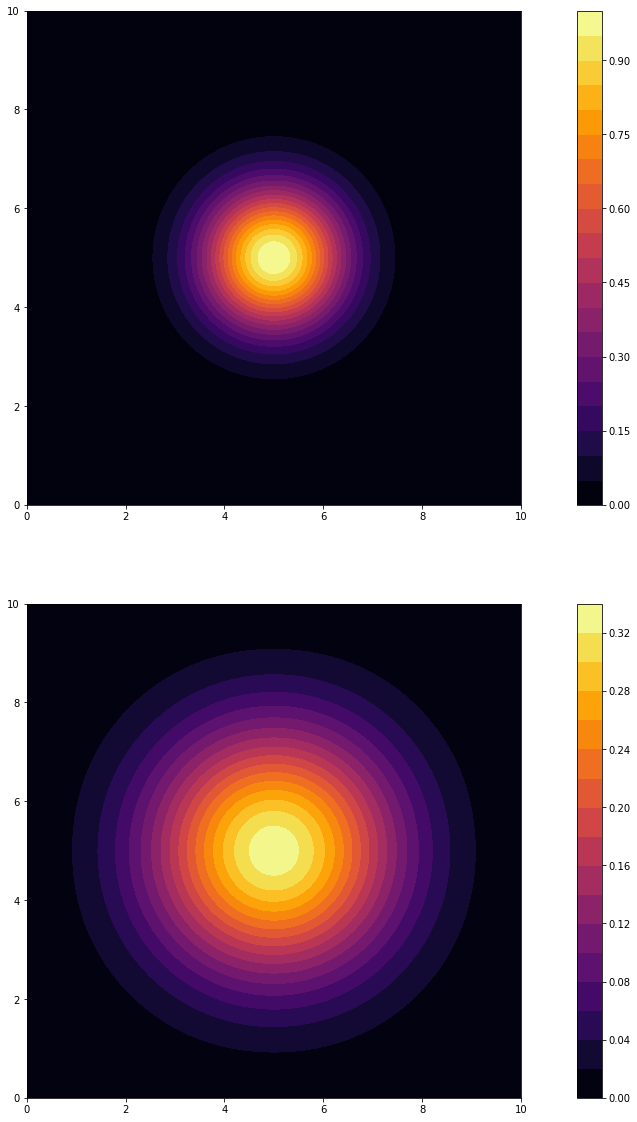

In [21]:
%time temp_final = simulation2D(temp, Fx, Fy, nt)
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)
im1 = ax1.contourf(X, Y, temp, 20, cmap='inferno')
ax1.set_aspect('equal')
plt.colorbar(im1)
ax2 = fig.add_subplot(212)
im2 = ax2.contourf(X, Y, temp_final, 20, cmap='inferno')
ax2.set_aspect('equal')
plt.colorbar(im2);